In [231]:
# import library
import tensorflow as tf
import numpy as np
import sys, os,cv2
from scipy.misc import imread,imresize
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from imgaug import augmenters as iaa
import imgaug as ia
from scipy.ndimage import zoom
from sklearn.utils import shuffle
import matplotlib.animation as animation
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from sklearn.datasets import make_blobs,make_moons,make_swiss_roll

plt.style.use('seaborn')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

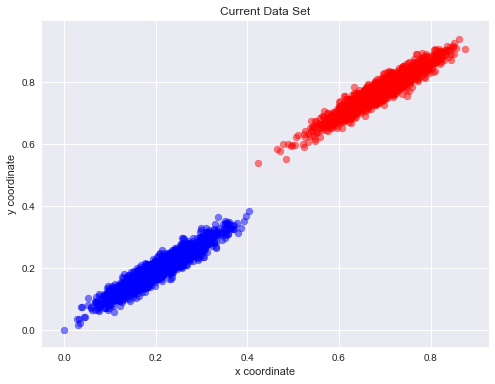

In [232]:
# load some data set
n_samples = 4000
X, y = make_blobs(n_samples=n_samples, random_state=123)
transformation = np.asarray([
    [3,1],
    [1,0]
])
X = X @ transformation
X = (X - X.min(0,keepdims=True)) / (X.max(0,keepdims=True) - X.min(0,keepdims=True))
plt.figure(figsize=(8,6))
plt.scatter(X[y==0, 0], X[y==0, 1], color='red',  alpha=0.5)
plt.scatter(X[y==1, 0], X[y==1, 1], color='blue', alpha=0.5)
plt.title('Current Data Set'); plt.ylabel('y coordinate'); plt.xlabel('x coordinate'); plt.grid(True)
plt.show()

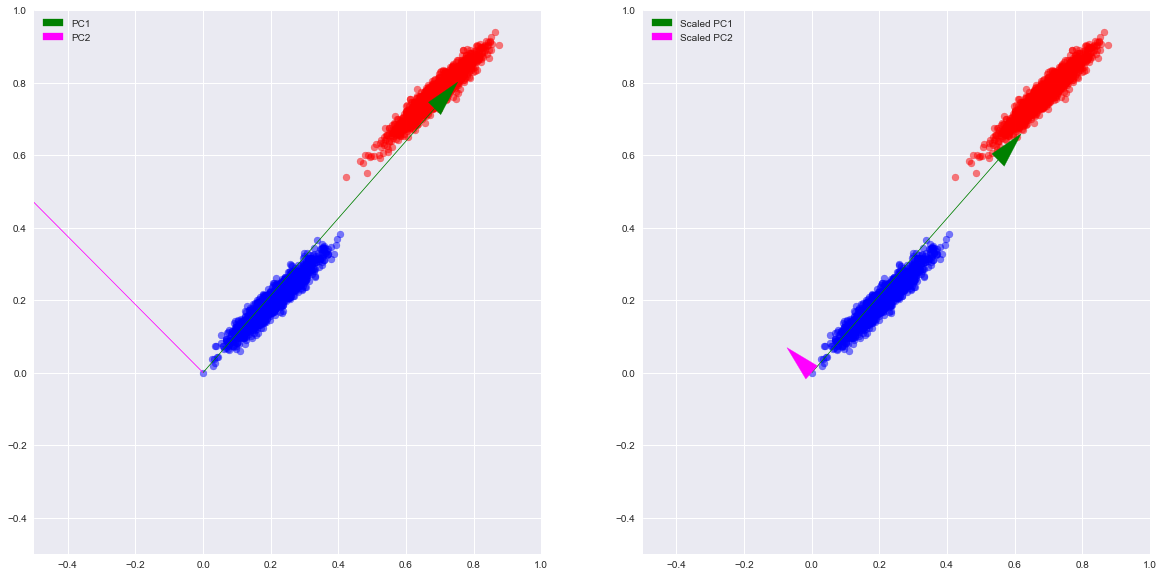

In [233]:
# Do EVD to see the projection matrix
X_cen      = X - X.mean(0,keepdims=True)
cov        = X.T @ X /(X.shape[0] - 1)
val,vec    = np.linalg.eigh(cov)

idx        = np.argsort(val)[::-1]
val        = val[idx]; vec = vec[:,idx]

plt.figure(figsize=(20,10)); 
plt.subplot(121); 
plt.scatter(X[y==0, 0], X[y==0, 1], color='red',  alpha=0.5)
plt.scatter(X[y==1, 0], X[y==1, 1], color='blue', alpha=0.5)
pca11=plt.arrow   (0, 0, *vec[:,0] , head_width=0.05, head_length=0.1,color='Green',  label='First PC')
pca12=plt.arrow   (0, 0, *vec[:,1] , head_width=0.05, head_length=0.1,color='magenta',label='Second PC')
plt.grid(True); plt.xlim(-.5,1); plt.ylim(-.5,1)
plt.legend([pca11,pca12],['PC1','PC2']);

plt.subplot(122); 
plt.scatter(X[y==0, 0], X[y==0, 1], color='red',  alpha=0.5)
plt.scatter(X[y==1, 0], X[y==1, 1], color='blue', alpha=0.5)
pca21=plt.arrow   (0, 0, *vec[:,0] * val[0], head_width=0.05, head_length=0.1,color='Green',  label='First PC')
pca22=plt.arrow   (0, 0, *vec[:,1] * val[1], head_width=0.05, head_length=0.1,color='magenta',label='Second PC')
plt.grid(True); plt.xlim(-.5,1); plt.ylim(-.5,1)

plt.legend([pca21,pca22],['Scaled PC1','Scaled PC2']);plt.show()

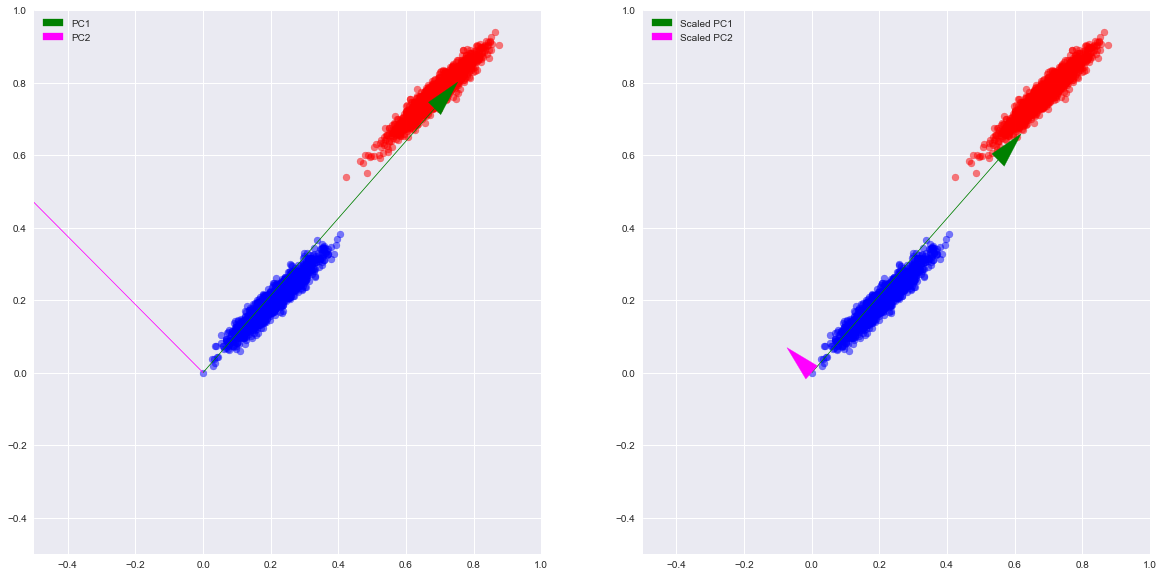

In [238]:
# Do SVD 
U,Sigma,VT = np.linalg.svd(X)
Sigma      = Sigma ** 2 / (X.shape[0]-1)

plt.figure(figsize=(20,10)); 
plt.subplot(121); 
plt.scatter(X[y==0, 0], X[y==0, 1], color='red',  alpha=0.5)
plt.scatter(X[y==1, 0], X[y==1, 1], color='blue', alpha=0.5)
pca11=plt.arrow   (0, 0, *-VT[:,0] , head_width=0.05, head_length=0.1,color='Green',  label='First PC')
pca12=plt.arrow   (0, 0, *VT[:,1] , head_width=0.05, head_length=0.1,color='magenta',label='Second PC')
plt.grid(True); plt.xlim(-.5,1); plt.ylim(-.5,1)
plt.legend([pca11,pca12],['PC1','PC2']);

plt.subplot(122); 
plt.scatter(X[y==0, 0], X[y==0, 1], color='red',  alpha=0.5)
plt.scatter(X[y==1, 0], X[y==1, 1], color='blue', alpha=0.5)
pca21=plt.arrow   (0, 0, *VT[:,0] * -Sigma[0], head_width=0.05, head_length=0.1,color='Green',  label='First PC')
pca22=plt.arrow   (0, 0, *VT[:,1] * Sigma[1], head_width=0.05, head_length=0.1,color='magenta',label='Second PC')
plt.grid(True); plt.xlim(-.5,1); plt.ylim(-.5,1)

plt.legend([pca21,pca22],['Scaled PC1','Scaled PC2']);plt.show()

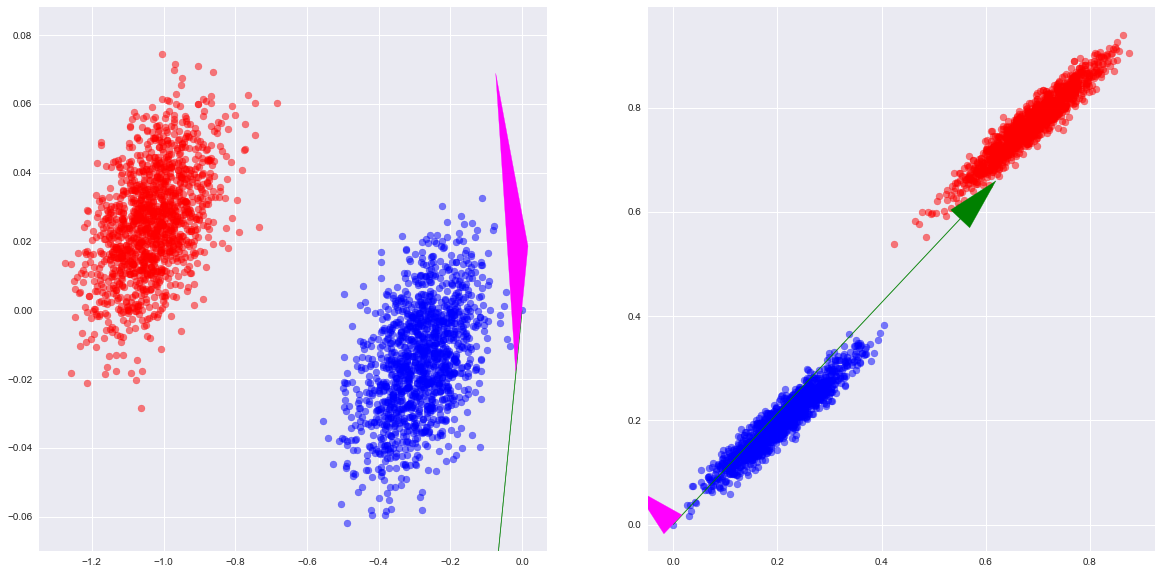

In [255]:
# perform PCA using SVD
U,Sigma,VT          = np.linalg.svd(X,full_matrices=False)
principle_component = U @ np.diag(Sigma)
Sigma_scaled        = Sigma ** 2 /(X.shape[0]-1)



plt.figure(figsize=(20,10)); 
plt.subplot(121); 
plt.scatter(principle_component[y==0, 0], principle_component[y==0, 1], color='red',  alpha=0.5)
plt.scatter(principle_component[y==1, 0], principle_component[y==1, 1], color='blue', alpha=0.5)
pca11=plt.arrow   (0, 0, *VT[:,0]* Sigma_scaled[0] , head_width=0.05, head_length=0.1,color='Green',  label='First PC')
pca12=plt.arrow   (0, 0, *VT[:,1]* Sigma_scaled[1] , head_width=0.05, head_length=0.1,color='magenta',label='Second PC')

plt.subplot(122); 
plt.scatter(X[y==0, 0], X[y==0, 1], color='red',  alpha=0.5)
plt.scatter(X[y==1, 0], X[y==1, 1], color='blue', alpha=0.5)
pca21=plt.arrow   (0, 0, *VT[:,0] *-Sigma_scaled[0], head_width=0.05, head_length=0.1,color='Green',  label='First PC')
pca22=plt.arrow   (0, 0, *VT[:,1] * Sigma_scaled[1], head_width=0.05, head_length=0.1,color='magenta',label='Second PC')

plt.show()

In [229]:
import numpy as np
from numpy import linalg as la
np.random.seed(42)


def flip_signs(A, B):
    """
    utility function for resolving the sign ambiguity in SVD
    http://stats.stackexchange.com/q/34396/115202
    """
    signs = np.sign(A) * np.sign(B)
    return A, B * signs


# Let the data matrix X be of n x p size,
# where n is the number of samples and p is the number of variables
n, p = 5, 3
X = np.random.rand(n, p)
# Let us assume that it is centered
X = X - X.mean(0,keepdims=True)

# the p x p covariance matrix
C = np.cov(X, rowvar=False)
# C is a symmetric matrix and so it can be diagonalized:
l, principal_axes = la.eigh(C)
# sort results wrt. eigenvalues
idx = l.argsort()[::-1]
l, principal_axes = l[idx], principal_axes[:, idx]
# the eigenvalues in decreasing order
print("l = \n", l)
# a matrix of eigenvectors (each column is an eigenvector)
print("V = \n", principal_axes)
# projections of X on the principal axes are called principal components
principal_components = X.dot(principal_axes)
print("Y = \n", principal_components)

# we now perform singular value decomposition of X
# "economy size" (or "thin") SVD
U, s, Vt = la.svd(X, full_matrices=False)
V = Vt.T
S = np.diag(s)

# 1) then columns of V are principal directions/axes.
assert np.allclose(*flip_signs(V, principal_axes))

# 2) columns of US are principal components
assert np.allclose(*flip_signs(U.dot(S), principal_components))

# 3) singular values are related to the eigenvalues of covariance matrix
assert np.allclose((s ** 2) / (n - 1), l)

# 8) dimensionality reduction
k = 2
PC_k = principal_components[:, 0:k]
US_k = U[:, 0:k].dot(S[0:k, 0:k])
assert np.allclose(*flip_signs(PC_k, US_k))

print(S[0:k, 0:k])

l = 
 [0.27418905 0.11232653 0.01969604]
V = 
 [[-0.53435576 -0.10510519  0.83869948]
 [ 0.79577968  0.27194755  0.54109078]
 [ 0.28495372 -0.95655498  0.06167616]]
Y = 
 [[ 0.5382821  -0.04170504  0.17101639]
 [-0.37801268  0.26959854 -0.10654358]
 [ 0.60281427  0.09375913 -0.14821045]
 [-0.31232627 -0.5572872  -0.03786103]
 [-0.45075742  0.23563458  0.12159868]]
[[1.04726129 0.        ]
 [0.         0.67030302]]


# Reference
1. tf.set_random_seed | TensorFlow. (2018). TensorFlow. Retrieved 28 October 2018, from https://www.tensorflow.org/api_docs/python/tf/set_random_seed
2. Comparing different hierarchical linkage methods on toy datasets — scikit-learn 0.20.0 documentation. (2018). Scikit-learn.org. Retrieved 28 October 2018, from http://scikit-learn.org/stable/auto_examples/cluster/plot_linkage_comparison.html#sphx-glr-auto-examples-cluster-plot-linkage-comparison-py
3. VanderPlas, J. (2018). Multiple Subplots | Python Data Science Handbook. Jakevdp.github.io. Retrieved 28 October 2018, from https://jakevdp.github.io/PythonDataScienceHandbook/04.08-multiple-subplots.html
4. object, M. (2018). Matplotlib returning a plot object. Stack Overflow. Retrieved 28 October 2018, from https://stackoverflow.com/questions/43925337/matplotlib-returning-a-plot-object
5. Plot randomly generated classification dataset — scikit-learn 0.20.0 documentation. (2018). Scikit-learn.org. Retrieved 28 October 2018, from http://scikit-learn.org/stable/auto_examples/datasets/plot_random_dataset.html#sphx-glr-auto-examples-datasets-plot-random-dataset-py
6. 5. Dataset loading utilities — scikit-learn 0.20.0 documentation. (2018). Scikit-learn.org. Retrieved 28 October 2018, from http://scikit-learn.org/stable/datasets/index.html
7. mplot3d tutorial — Matplotlib 2.0.2 documentation. (2018). Matplotlib.org. Retrieved 28 October 2018, from https://matplotlib.org/mpl_toolkits/mplot3d/tutorial.html
8. matplotlib, H. (2018). How to plot vectors in python using matplotlib. Stack Overflow. Retrieved 28 October 2018, from https://stackoverflow.com/questions/42281966/how-to-plot-vectors-in-python-using-matplotlib
9. arrow, M. (2018). Matplotlib legend for an arrow. Stack Overflow. Retrieved 28 October 2018, from https://stackoverflow.com/questions/22348229/matplotlib-legend-for-an-arrow
10. plt colors - Google Search. (2018). Google.ca. Retrieved 28 October 2018, from https://www.google.ca/search?q=plt+colors&rlz=1C1CHBF_enCA771CA771&oq=plt+colors&aqs=chrome..69i57j0l5.1038j0j7&sourceid=chrome&ie=UTF-8
11. Brownlee, J. (2018). A Gentle Introduction to Singular-Value Decomposition for Machine Learning. Machine Learning Mastery. Retrieved 28 October 2018, from https://machinelearningmastery.com/singular-value-decomposition-for-machine-learning/
12. 